# Udacity Self-Driving Car Nanodegree
## Advanced Lane Finding Project

Steps of the Project:

*  Step-I : Computataion of the camera calibration matrix and distortion coefficients given a set of chessboard images.

* Step-II: Application of a distortion correction to raw images.
* Step-III: Use of color transforms and gradients to create a thresholded binary image.
* Step-IV:  Application of a perspective transform to rectify binary image ("birds-eye view").
* Step-V: Detection of lane pixels and fit to find the lane boundary.
* Step-VI: Determination of the curvature of the lane and vehicle position with respect to center.
* Step-VII: Warping the detected lane boundaries back onto the original image.
* Step-VIII: Output the visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


### Imports

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from tqdm import tqdm
import matplotlib.image as mpimg
#import seaborn as sns

%matplotlib inline

### 1. Camera Calibtration

#### 1.1. Draw Chessboard corners

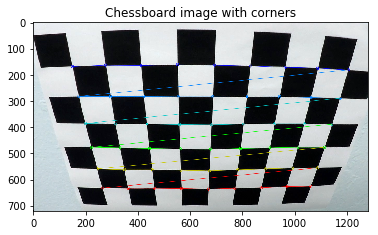

In [2]:
# Load chessboard images
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)

# prepare object points
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard image with corners")
    plt.show()

#### 1.2. Collect all corners, object points and image points

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # If found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        

camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration2.jpg
camera_cal/calibration20.jpg
camera_cal/calibration3.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg


#### 1.3. Calibrate Camera

In [4]:
# Test undistortion on an image
fname = 'camera_cal/calibration{}.jpg'.format(3)
img = cv2.imread(fname)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort the image
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )


* Camera Matrix: [Camara Calibration](http://docs.opencv.org/2.4.1/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)

$ A = \begin{bmatrix}
    f_{x} & 0 & c_x \\
    0 & f_y & c_y \\
   0 & 0 & l \\
\end{bmatrix}$

In [5]:
mtx

array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
       [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

* Distortion Coefficients

In [6]:
dist

array([[ -2.41017956e-01,  -5.30721173e-02,  -1.15810355e-03,
         -1.28318856e-04,   2.67125290e-02]])

---------

### 2. Undistort Image

#### 2.1 Function to undistort using calibration

In [7]:
# undistort image using camera calibration matrix from above
def undistort(img,calibration):
    mtx = calibration['mtx']
    dist = calibration['dist']
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

##### 2.2 Application of distortion in test images

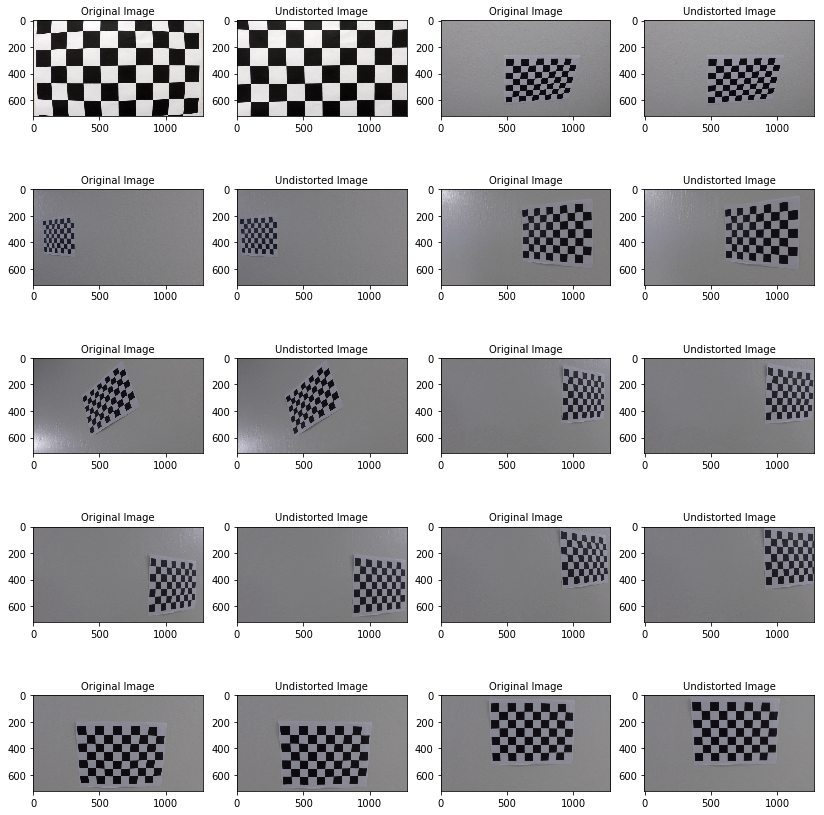

In [8]:
calibration = pickle.load( open( "calibration.p", "rb" ) )
directory = './camera_cal/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(14, 15))

count = 1
for k,Img in enumerate(globDir):
    Img = cv2.imread(Img)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    Img_undistort = undistort(Img,calibration)
    
    #fig-1
    fig.add_subplot(5,4,count)
    plt.imshow(Img)
    plt.title('Original Image', fontsize=10)
    
    #fig-2
    count += 1
    fig.add_subplot(5,4,count)
    plt.imshow(Img_undistort)
    plt.title('Undistorted Image', fontsize=10)
    
    count += 1
    
    if count > 20:
        break
    

------

### 3.Perspective Transform

##### 3.1 Function to warp

In [9]:
def warper(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

##### 3.2 Setting up source and destination points

In [10]:
# upload camera calibration
calibration = pickle.load( open( "calibration.p", "rb" ) )

apex, apey = 360, 258
offset_far = 50
offset_near = 50


# source points
src = np.float32([[int(apex-offset_far),apey],
                  [int(apex+offset_far),apey],
                  [int(0+offset_near),390],
                  [int(720-offset_near),390]])


#destination points
dst = np.float32([[0,0],[720,0],[0,405],[720,405]])


In [11]:
dst[0,0]

0.0

##### 3.3 Sample application of Perspective transform

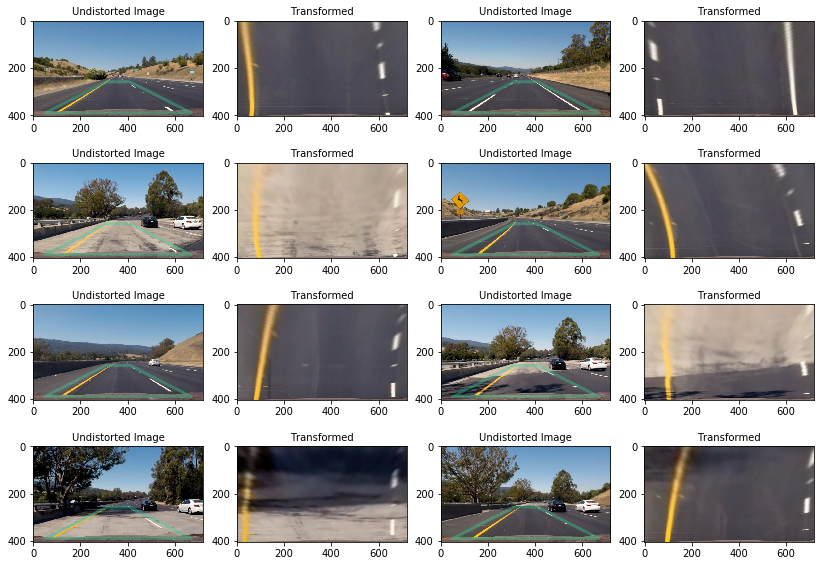

In [12]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(14, 10))

counter = 1
for Img in globDir:
    Img = cv2.imread(Img)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    Img = cv2.resize(Img, (720, 405))
    
    
    Img = undistort(Img,calibration)
    Img_unwarp,M,Minv = warper(Img, src, dst)
    
    x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
    y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
    
    #fig-1
    fig.add_subplot(4,4,counter)
    counter += 1
    plt.imshow(Img)
    plt.title('Undistorted Image', fontsize=10)
    plt.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    
        
    
    #fig-2
    fig.add_subplot(4,4,counter)
    counter += 1
    plt.imshow(Img_unwarp)
    plt.title('Transformed', fontsize=10)
    
    

------

### 4. Gradient and Threshold

-------

#### 4.1. All gradient and thresshold in Gradient Class

In [13]:
class Gradient(object):
    
    
    def __init__(self,img,sobel_kernel):
        
        self.img = img
        self.sobel_kernel = sobel_kernel
        
        # Convert to grayscale
        self.gray = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY).astype(np.float)
        self.hsv = cv2.cvtColor(self.img, cv2.COLOR_RGB2HSV).astype(np.float)
        self.hls = cv2.cvtColor(self.img, cv2.COLOR_RGB2HLS).astype(np.float)
        self.lab = cv2.cvtColor(self.img, cv2.COLOR_RGB2Lab).astype(np.float)
        
        # Calculate the x and y gradients
        self.sobelx = cv2.Sobel(self.gray, cv2.CV_64F, 1, 0, ksize=self.sobel_kernel)
        self.sobely = cv2.Sobel(self.gray, cv2.CV_64F, 0, 1, ksize=self.sobel_kernel)
       
        
    def abs_sobel_thresh(self,orient,thresh=(0, 255)):
        # Apply x or y gradient with the OpenCV Sobel() function
        if orient == 'x':
             sobel = self.sobelx
        elif orient == 'y':
             sobel = self.sobely
        else:
            raise ValueError('orient has to be "x" or "y" not "%s"' % orient)
        # and take the absolute value
        abs_sobel = np.absolute(sobel)
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        # Return the result
        return binary_output
    
    
    
    def mag_thresh(self, mag_thresh=(0, 255)):
        # Calculate the gradient magnitude
        gradmag = np.sqrt(self.sobelx**2 + self.sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    
    def dir_thresh(self, thresh=(0, np.pi/2)):
        # Take the absolute value of the gradient direction, 
        absgraddir = np.arctan2(np.absolute(self.sobely), np.absolute(self.sobelx))
        binary_output =  np.zeros_like(absgraddir)
        # apply a threshold, and create a binary image result
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    
    def hls_lthresh(self,thresh=(220, 255)):
        hls_l = self.hls[:,:,1]
        hls_l = hls_l*(255/np.max(hls_l))
        # 2) Apply a threshold to the L channel
        binary_output = np.zeros_like(hls_l)
        binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
        # 3) Return a binary image of threshold result
        return binary_output
    
    
    def lab_bthresh(self, thresh=(190,255)):
        lab_b = self.lab[:,:,2]
        # don't normalize if there are no yellows in the image
        if np.max(lab_b) > 175:
            lab_b = lab_b*(255/np.max(lab_b))
        # 2) Apply a threshold to the L channel
        binary_output = np.zeros_like(lab_b)
        binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
        # 3) Return a binary image of threshold result
        return binary_output
    

#### 4.2. Application of Gradient and Threshold on test images

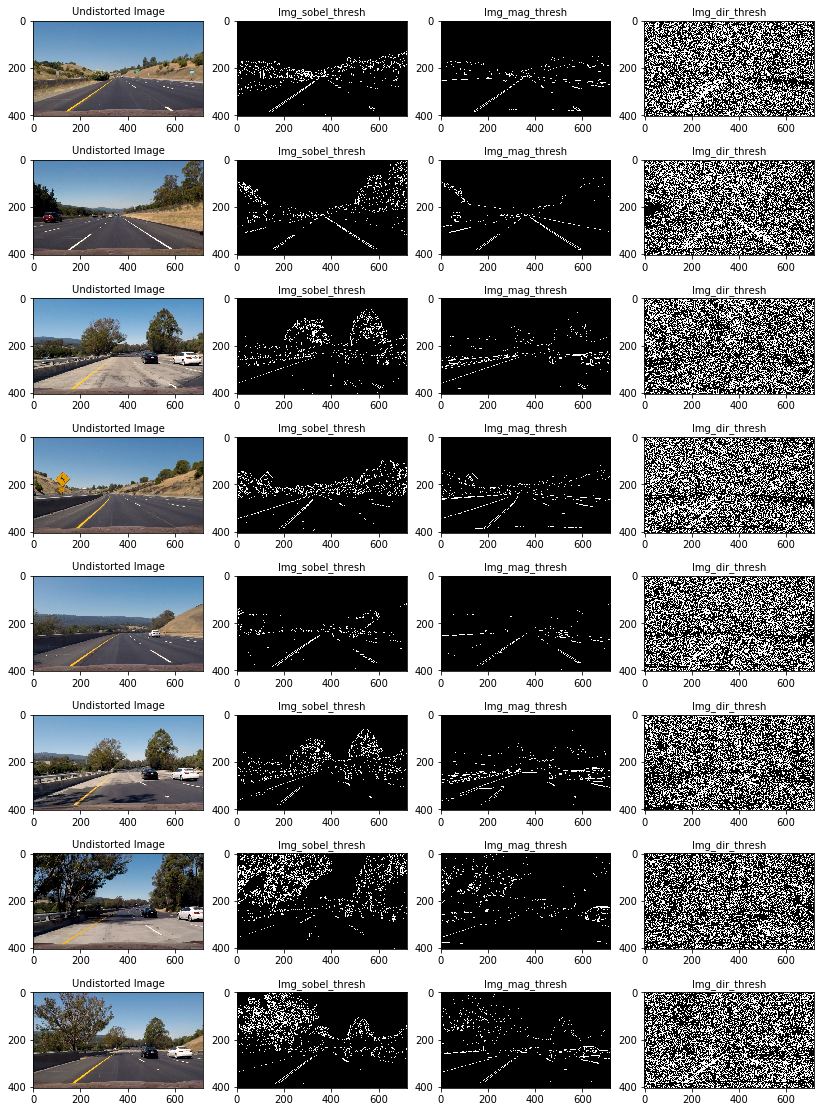

In [14]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(14, 20))

counter = 1
for Img in globDir:
    Img = cv2.imread(Img)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    Img = cv2.resize(Img, (720, 405))
    
    GD = Gradient(Img,sobel_kernel =3)
    Img_abs_sobel_thresh = GD.abs_sobel_thresh(orient='x',thresh= (30,130))
    Img_mag_thresh = GD.mag_thresh(mag_thresh=(80, 255))
    Img_dir_thresh = GD.dir_thresh(thresh=(0.7, 1.3))
    
    #fig-1
    fig.add_subplot(8,4,counter)
    counter += 1
    plt.imshow(Img)
    plt.title('Undistorted Image', fontsize=10)
    
    #fig-2
    fig.add_subplot(8,4,counter)
    counter += 1
    plt.imshow(Img_abs_sobel_thresh,cmap='gray')
    plt.title('Img_sobel_thresh', fontsize=10)
    
    #fig-3
    fig.add_subplot(8,4,counter)
    counter += 1
    plt.imshow(Img_mag_thresh,cmap='gray')
    plt.title('Img_mag_thresh', fontsize=10)
    
    #fig-4
    fig.add_subplot(8,4,counter)
    counter += 1
    plt.imshow(Img_dir_thresh,cmap='gray')
    plt.title('Img_dir_thresh', fontsize=10)


--------

### 5. Binary Image Pipeline : undistort -> unwarp -> binary threshold

---------

In [15]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
# (hopefully)
def pipeline(Img):
    # Undistort
    calibration = pickle.load( open( "calibration.p", "rb" ) )
    Img_undistort = undistort(Img,calibration)
    
    h,w = Img_undistort.shape[:2]

    # define source and destination points for transform
    src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])

    dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
    
    # Perspective Transform
    Img_unwarp, M, Minv = warper(Img_undistort, src, dst)

    GD =  Gradient(Img_unwarp,sobel_kernel=3)
    
    # HLS L-channel Threshold (using default parameters)
    Img_LThresh = GD.hls_lthresh()

    # Lab B-channel Threshold (using default parameters)
    Img_BThresh = GD.lab_bthresh()
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(Img_BThresh)
    combined[(Img_LThresh == 1) | (Img_BThresh == 1)] = 1
    return combined, Minv

##### 5.1  Application of  Pipeline on Test Images

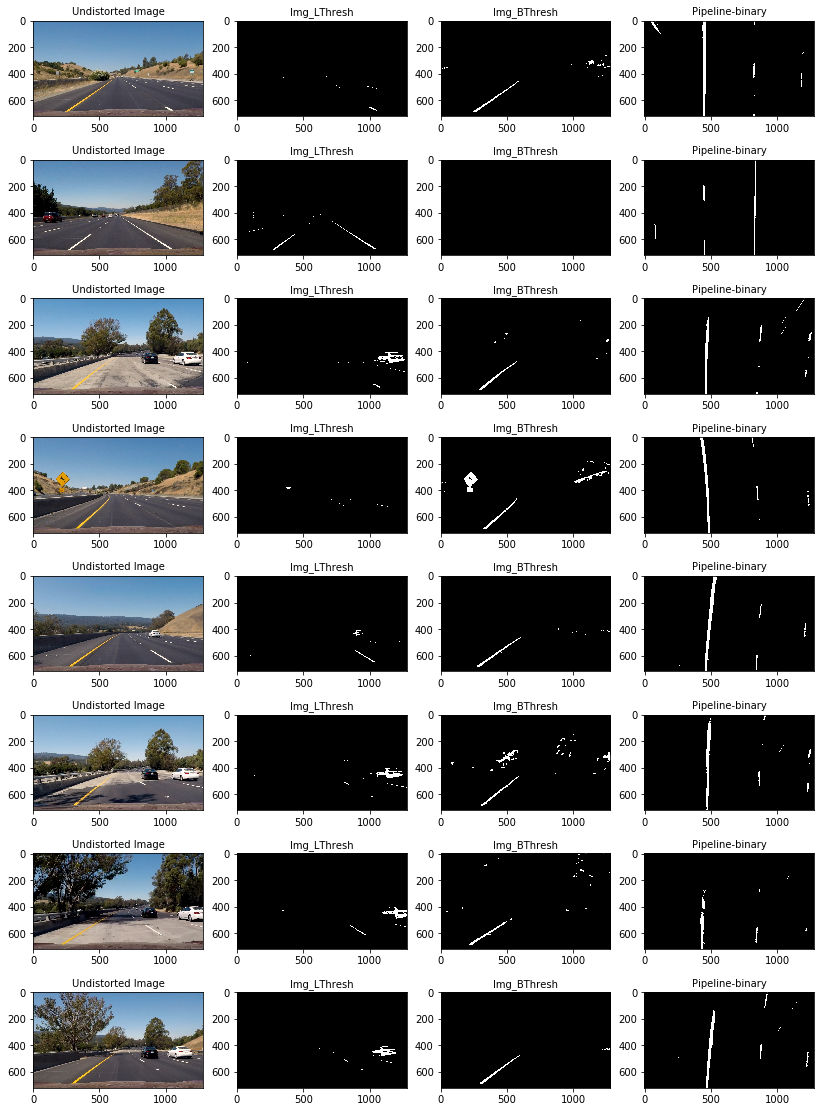

In [16]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(14, 20))

counter = 1
for Img in globDir:
    Img = cv2.imread(Img)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    #Img = cv2.resize(Img, (720, 405))
    
    
    GD = Gradient(Img,sobel_kernel =3)
    Img_LThresh = GD.hls_lthresh()
    Img_BThresh = GD.lab_bthresh()
    
    
    #fig-1
    fig.add_subplot(8,4,counter)
    counter += 1
    plt.imshow(Img)
    plt.title('Undistorted Image', fontsize=10)
    
    
    #fig-2
    fig.add_subplot(8,4,counter)
    counter += 1
    plt.imshow(Img_LThresh,cmap='gray')
    plt.title('Img_LThresh', fontsize=10)
    
    #fig-3
    fig.add_subplot(8,4,counter)
    counter += 1
    plt.imshow(Img_BThresh,cmap='gray')
    plt.title('Img_BThresh', fontsize=10)
    
    Img_bin, Minv = pipeline(Img)
    
    #fig-4
    fig.add_subplot(8,4,counter)
    counter += 1
    plt.imshow(Img_bin,cmap='gray')
    plt.title('Pipeline-binary', fontsize=10)


-------

### 6. Sliding Window Polyfit

-------

##### 6.1. Collection of all useful function under class PolyFit

In [17]:
class PolyFit(object):
    
    def __init__(self,img):
        self.img=img
        self.nwindows = 10
        self.window_h = np.int(self.img.shape[0]/self.nwindows)

        self.out_img = np.dstack((img, img, img))
        
        # Set the width of the windows +/- margin
        self.margin = 80

        # Set minimum number of pixels found to recenter window
        self.minpix = 40
        
    def histogram(self,verbose=False):
        histogram = np.sum(self.img[np.int(self.img.shape[0]/2):,:], axis=0)
        if verbose:
            plt.plot(histogram)
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        return leftx_base, rightx_base
     
        
    def poly_coff(self,leftx,lefty,rightx,righty):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        return left_fit,right_fit    
        
        
    def sliding_window_polyfit(self,verbose=False):
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # Rectangle data for visualization
        rectangle_data = []
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_base,rightx_base = self.histogram(verbose=False)
        
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        #Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.img.shape[0] - (window+1)*self.window_h
            win_y_high = self.img.shape[0] - window*self.window_h
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            
            rectangle_data.append((win_y_low, win_y_high,\
                                   win_xleft_low, win_xleft_high,\
                                   win_xright_low, win_xright_high))
    
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
              (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
    
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)


        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
            
        left_fit,right_fit = self.poly_coff(leftx,lefty,rightx,righty)
            
        return left_fit,right_fit,left_lane_inds,right_lane_inds, rectangle_data
    
    def polyfit_using_prev_fit(self, left_fit_prev, right_fit_prev):
    
        nonzero = self.img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
    
        left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) +\
                                   left_fit_prev[1]*nonzeroy + left_fit_prev[2] - self.margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) +\
                                   left_fit_prev[1]*nonzeroy + left_fit_prev[2] + self.margin))) 
    
        right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) +\
                                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] - self.margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) +\
                                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + self.margin)))  
    

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    
        left_fit_new, right_fit_new = (None, None)
    
        if len(leftx) != 0:
            # Fit a second order polynomial to each
            left_fit_new = np.polyfit(lefty, leftx, 2)
        if len(rightx) != 0:
            right_fit_new = np.polyfit(righty, rightx, 2)
        
        return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
    
    def plot_ploy(self,l_fit,r_fit):
        ploty = np.linspace(0, self.img.shape[0]-1, self.img.shape[0] )
        left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + left_fit[2]
        right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + right_fit[2]
        return ploty,left_fitx,right_fitx
    
    def draw_rectangle(self,rectangles,left_lane_inds, right_lane_inds,out_image):
        for rect in rectangles:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
            cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    
    
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
        return out_image
    
    def skip_window_search(self, left_fit, right_fit):

        
        left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = \
              self.polyfit_using_prev_fit(left_fit, right_fit)

        _,left_fitx2,right_fitx2 = self.plot_ploy(left_fit2,right_fit2)      
    

        # Create an image to draw on and an image to show the selection window
        out_img = np.uint8(np.dstack((self.img,self.img,self.img))*255)
        window_img = np.zeros_like(out_img)


        # Color in left and right line pixels
        nonzero = self.img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]


        # Generate a polygon to illustrate the search window area (OLD FIT)
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+self.margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+self.margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))


        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
        return result,left_fit2, right_fit2
    
    def curvature_and_center_dist(self, l_fit, r_fit, l_lane_inds, r_lane_inds):
    
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
        xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    
    
        left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        h = self.img.shape[0]
        ploty = np.linspace(0, h-1, h)
        y_eval = np.max(ploty)
  

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        # Again, extract left and right line pixel positions
        leftx = nonzerox[l_lane_inds]
        lefty = nonzeroy[l_lane_inds] 
        rightx = nonzerox[r_lane_inds]
        righty = nonzeroy[r_lane_inds]
    
    
        if len(leftx) != 0 and len(rightx) != 0:
        
            # Fit new polynomials to x,y in world space
            left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
            # Calculate the new radii of curvature
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix +\
                               left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix +\
                                right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        
            # Now our radius of curvature is in meters
            # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
        if r_fit is not None and l_fit is not None:
            car_position = self.img.shape[1]/2
            l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
            r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
            lane_center_position = (r_fit_x_int + l_fit_x_int) /2
            center_dist = (car_position - lane_center_position) * xm_per_pix
        
        return left_curverad, right_curverad, center_dist

---------

##### 6.2. Application of sliding window search on test images

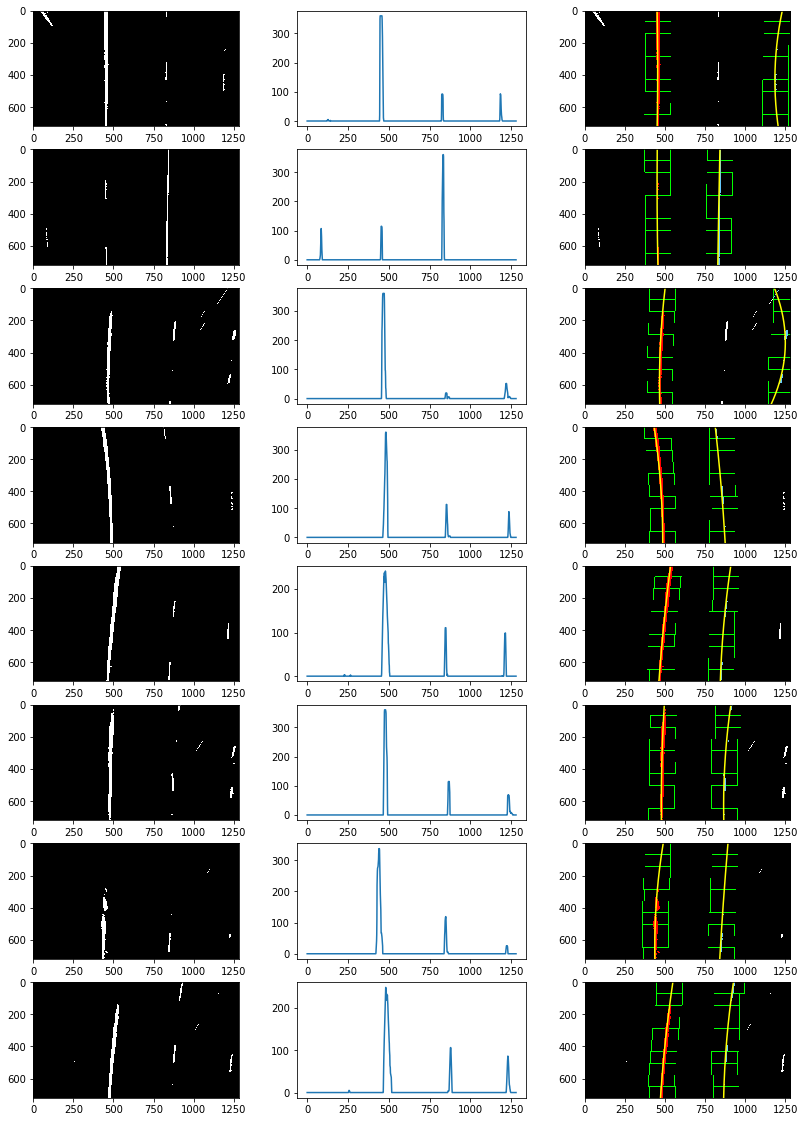

In [18]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(14, 20))
counter = 1
for Img in globDir:
    Img = cv2.imread(Img)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    Img_bin, Minv = pipeline(Img)
    
    #fig-1
    fig.add_subplot(8,3,counter)
    counter += 1
    plt.imshow(Img_bin, cmap = 'gray') 
    
    #fig-2
    fig.add_subplot(8,3,counter)
    counter += 1
    histogram =  np.sum(Img_bin[np.int(Img_bin.shape[0]/2):,:], axis=0)
    plt.plot(histogram)
    
    #fig-3
    fig.add_subplot(8,3,counter)
    counter += 1
    PF = PolyFit(Img_bin)
    left_fit, right_fit, left_lane_inds,right_lane_inds, rectangles\
        = PF.sliding_window_polyfit()
    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((Img_bin,Img_bin,Img_bin))*255)
    # Generate x and y values for plotting
    ploty,left_fitx,right_fitx = PF.plot_ploy(left_fit,right_fit)
    out_image = PF.draw_rectangle(rectangles,left_lane_inds, right_lane_inds,out_img)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    

-------

##### 6.3.  Application Fit from Previous Frame on test images


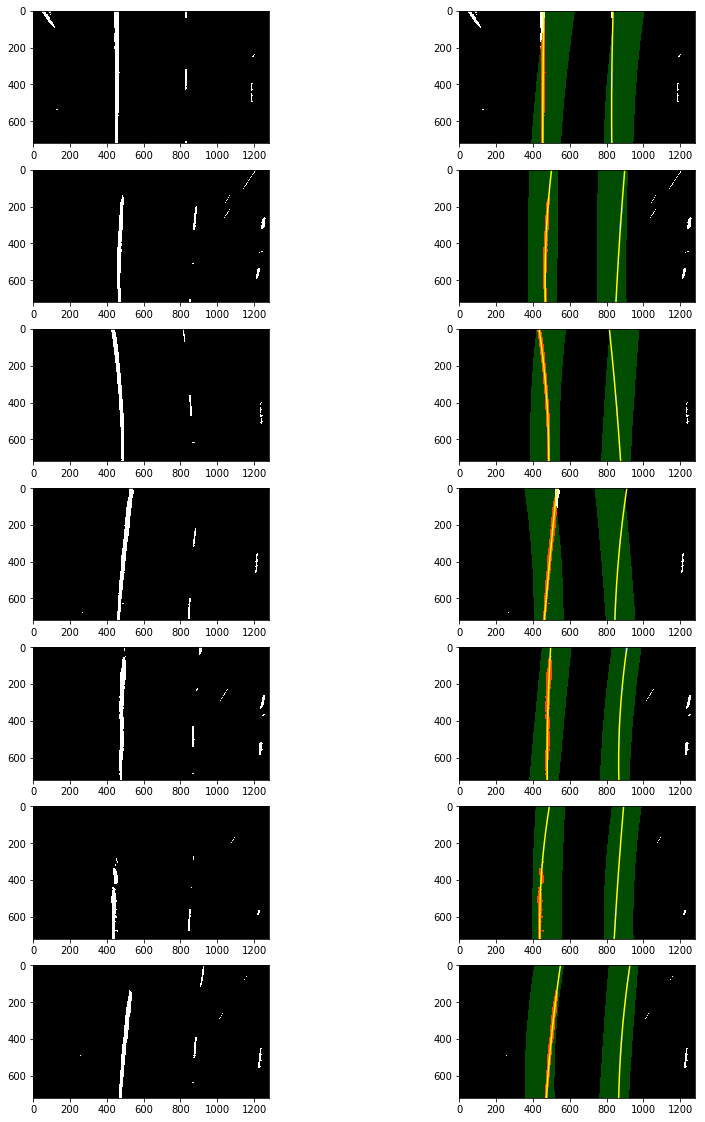

In [19]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(14, 20))
counter = 1
for i,Img in enumerate(globDir):
    Img = cv2.imread(Img)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    Img_bin, Minv = pipeline(Img)
    
    if i==1:
        PF = PolyFit(Img_bin)
        left_fit, right_fit, left_lane_inds,right_lane_inds, rectangles\
                    = PF.sliding_window_polyfit()
            
    else:
        
        #fig-1
        fig.add_subplot(7,2,counter)
        counter += 1
        plt.imshow(Img_bin, cmap = 'gray') 
    
        #fig-2
        fig.add_subplot(7,2,counter)
        counter += 1
        
        PF = PolyFit(Img_bin)
        result,left_fit2, right_fit2 = \
             PF.skip_window_search(left_fit, right_fit)
        left_fit, right_fit = left_fit2, right_fit2
        
        ploty,left_fitx,right_fitx = PF.plot_ploy(left_fit,right_fit) 
        
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

--------

### 7. Radius of Curvature and Distance from Lane Center Calculation

##### 7.1. Calculation of Radius of curvature and lane Center

In [20]:
Img = cv2.imread('./test_images/test2.jpg')
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)

Img_bin, Minv = pipeline(Img)

PF = PolyFit(Img_bin)
left_fit, right_fit, left_lane_inds, \
right_lane_inds, ractangles = PF.sliding_window_polyfit()


PF= PolyFit(Img_bin)
rad_l, rad_r, d_center = PF.curvature_and_center_dist(left_fit, right_fit,\
                                                       left_lane_inds,\
                                                       right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 454.578612261 m, 1251.36494563 m
Distance from lane center for example: -0.398464566177 m


##### 7.2. Function to display information

In [21]:
def display_info(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

##### 7.3. Function to draw lane

In [22]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, unwarp, 0.5, 0)
    return result

-----------

##### 7.4. Application of draw lane and display function on test images

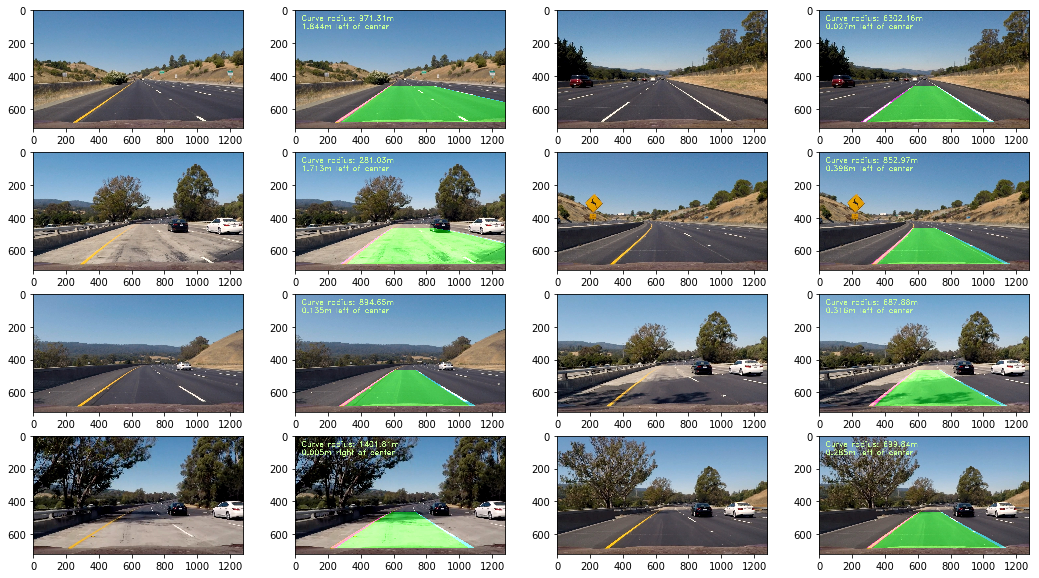

In [23]:
directory = './test_images/*.jpg'
globDir = glob.glob(directory)
fig = plt.figure(figsize=(18,10))
counter = 1
for Img in globDir:
    Img = cv2.imread(Img)
    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
    Img_bin, Minv = pipeline(Img)
    
    PF = PolyFit(Img_bin)
    left_fit, right_fit, left_lane_inds, \
        right_lane_inds, ractangles = PF.sliding_window_polyfit()
        
    rad_l, rad_r, d_center = PF.curvature_and_center_dist(left_fit, right_fit,\
                                                       left_lane_inds,\
                                                       right_lane_inds)
        
    Img_out = draw_lane(Img,Img_bin, left_fit, right_fit, Minv)
    Img_out = display_info(Img_out, (rad_l+rad_r)/2, d_center)
    
    #plot-1
    fig.add_subplot(4,4,counter)
    plt.imshow(Img)
    counter += 1
    
    #plot-2
    fig.add_subplot(4,4,counter)
    plt.imshow(Img_out)
    counter += 1
    
    

-------

### 8. Image Processing

-------

##### 8.1. Line class to update the lane data in video frames

In [24]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                    self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

##### 8.2. Function to check distance between lanes

In [25]:
 def intercept_checker(l_fit,r_fit,img):   
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
    return l_fit,r_fit        

----------

##### 8.3. Final Image Processing Pipeline

In [26]:
def ImageProcessing(img):
    
    new_img = np.copy(img)
    
    img_bin, Minv = pipeline(new_img)
    
    PF=PolyFit(img_bin)
    
    # if both left and right lines were detected last frame,
    # use polyfit_using_prev_fit, otherwise use sliding window
    
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ =\
                            PF.sliding_window_polyfit()
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = \
             PF.polyfit_using_prev_fit(l_line.best_fit, r_line.best_fit)
        
    l_fit,r_fit = intercept_checker(l_fit,r_fit,img)    
   
            
    # update line        
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        # draw lane
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        # calculate curvature
        rad_l, rad_r, d_center = PF.curvature_and_center_dist(l_line.best_fit, r_line.best_fit, 
                                                             l_lane_inds, r_lane_inds)
        # display info 
        img_out = display_info(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    return img_out


----------

### Processing Project Videos

#### 9.1 Process Project Video

In [41]:
l_line = Line()
r_line = Line()
videoOutput_1 = 'project_video_output.mp4'
videoInput_1 = VideoFileClip('project_video.mp4')
processed_video = videoInput_1.fl_image(ImageProcessing)
%time processed_video.write_videofile(videoOutput_1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:09<00:00,  5.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 48s, sys: 1min 8s, total: 4min 57s
Wall time: 4min 10s


-------

#### 9.2.  Process Challenge Video

In [51]:
l_line = Line()
r_line = Line()
videoOutput_2 = 'challenge_video_output.mp4'
videoInput_2 = VideoFileClip('challenge_video.mp4')
processed_video = videoInput_2.fl_image(ImageProcessing)
%time processed_video.write_videofile(videoOutput2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:00<00:00,  7.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 1min 6s, sys: 8.22 s, total: 1min 14s
Wall time: 1min 1s


-------

#### 9.3. Process Harder Challenge Video

In [52]:
l_line = Line()
r_line = Line()
videoOutput_3 = 'harder_challenge_video_output.mp4'
videoInput_3 = VideoFileClip('harder_challenge_video.mp4')
processed_video = videoInput3.fl_image(ImageProcessing)
%time processed_video.write_videofile(videoOutput_3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [03:22<00:00,  6.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 3min 15s, sys: 29.8 s, total: 3min 45s
Wall time: 3min 23s


---------